In [197]:
# Authorin: Phuong Huong Nguyen
# Date: 26.2.2023

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

## I. Import Dataset

In [99]:
df_re = pd.read_csv("borrower_registrations.csv", index_col=0)
df_re.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded
0,310426050,Existenzgründung,2017-01-01 01:04:00,1975.0,12.0,DE,f,10.0,ledig,zur Miete,2016-07-05 00:00:00,Bayern,f74d39fa044aa309eaea14b9f57fe79c
1,310426380,Möbel / Renovierung / Umzug,2017-01-01 01:41:12,1985.0,11.0,DE,f,25.0,ledig,zur Miete,2014-02-02 00:00:00,Hessen,47410c608c49e7a0a0708031355608e1
2,310426710,Möbel / Renovierung / Umzug,2017-01-01 02:24:30,1959.0,1.0,DE,m,5.0,getrennt lebend,zur Miete,2014-04-04 00:00:00,Hessen,38ec103fb9e09bf2354c72a5768e4f24
3,310426875,Autokredit,2017-01-01 02:29:23,1994.0,12.0,DE,m,6.5,ledig,bei den Eltern,1997-03-05 00:00:00,Schlewig-Holstein,e4c865c1d21d64f32364e30ec075af6a
4,310427040,Möbel / Renovierung / Umzug,2017-01-01 02:54:53,1981.0,1.0,DE,f,6.5,ledig,bei den Eltern,2014-10-03 00:00:00,Baden-Württemberg,83c04328c2935e8aef7cdd3eb4395d04


In [100]:
df_lab = pd.read_csv("borrower_labels.csv", sep="|")
df_lab.head(10)

,user_id,flag_filled_page_2
0,310426050,1
1,310426380,0
2,310426710,0
3,310426875,1
4,310427040,1
5,310427205,1
6,310427535,1
7,310427700,0
8,310428030,0
9,310428195,1


## II. Data Analysis and handling missing data

### 1. Analyzing missing data


In [101]:
df_re.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146829 entries, 0 to 146828
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    146829 non-null  int64  
 1   Verwendungszweck           146800 non-null  object 
 2   Registrierungsdatum        146829 non-null  object 
 3   Jahr_Geburt                146823 non-null  float64
 4   Monat_Geburt               146823 non-null  float64
 5   Staatsangehörigkeit        146823 non-null  object 
 6   Geschlecht                 146829 non-null  object 
 7   angefragtes_Kreditvolumen  146800 non-null  float64
 8   Familienstand              146829 non-null  object 
 9   Wohnsituation              146829 non-null  object 
 10  dort_wohnhaft_seit         146829 non-null  object 
 11  Bundesland                 130582 non-null  object 
 12  email_domain_encoded       146829 non-null  object 
dtypes: float64(3), int64(1), obje

In [102]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146829 entries, 0 to 146828
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   user_id             146829 non-null  int64
 1   flag_filled_page_2  146829 non-null  int64
dtypes: int64(2)
memory usage: 2.2 MB


In [103]:
# Caculating the percentage of missing data in df_re. Then we can decide the way to deal with these missing data
print("The percentage of missing data in each column of borrowed_registrations:")
for col in df_re.columns:
    missing_data = df_re[col].isna().sum()
    missing_percent = round((missing_data / len(df_re))*100, 3)
    print(f"{col}: \t\t\t {missing_percent} % ")

The percentage of missing data in each column of borrowed_registrations:
user_id: 			 0.0 % 
Verwendungszweck: 			 0.02 % 
Registrierungsdatum: 			 0.0 % 
Jahr_Geburt: 			 0.004 % 
Monat_Geburt: 			 0.004 % 
Staatsangehörigkeit: 			 0.004 % 
Geschlecht: 			 0.0 % 
angefragtes_Kreditvolumen: 			 0.02 % 
Familienstand: 			 0.0 % 
Wohnsituation: 			 0.0 % 
dort_wohnhaft_seit: 			 0.0 % 
Bundesland: 			 11.065 % 
email_domain_encoded: 			 0.0 % 


**Considering to handle missing values:**
* From the above, we see that the column **Bundesland** has a huge amount of missing data. Because this column contains categorical variables and it may not correct if we just fill missing data with the most frequent value in this column. So, i think we should analyse this column more detail
* For other columns, the volume of missing values are small. We can consider to handle it or just simple remove the rows with missing data. I will choose to handle missing values. 
* For column **Verwendungszweck**, i fill missing values with the most frequent category in this column
* For column **Staatsangehörigkeit**, i fill missing values with **DE**
* For columns **Jahr_Geburt** and **Monat_Geburt**, i fill missing values with Mean value of each column

### 2. Analysing data in file borrowed_registrations.csv

#### a. Column `Staatsangehörigkeit`

* This column contains only 2 variables: DE or nan. 
* That means most users are from Germany. And our service is applied in frame of Germany 
* In this case, i think users' nationality doesn't play a big role in decision of borrowing money. So I tend to remove this feature from training model. 

In [104]:
df_re["Staatsangehörigkeit"].unique()

array(['DE', nan], dtype=object)

#### b. Column `email_domain_encoded`
* There is no dupliated user_id value in file borrowed_registrations.csv, but i found that one user_id can own more than one `email_domain`

* I'm considering whether `email_domain_encoded` is an important feature or not. If it's not, we don't need to use this feature to train the model

In [105]:
df_re["user_id"].nunique()

146829

In [106]:
df_re["user_id"].duplicated().any()

False

In [107]:
df_re['email_domain_encoded'].nunique()

6056

#### c. Column `Verwendungszweck`
* We can see that `sonstiges` occupies the most percentage of variables in column `Verwendungszweck`. Hence, I will fill the missing values of this column with `sonstiges`

In [108]:
df_re["Verwendungszweck"].unique()

array(['Existenzgründung', 'Möbel / Renovierung / Umzug', 'Autokredit',
       'sonstiges', 'Ausgleich Girokonto / Dispo', 'Urlaub',
       'Ausbildungsfinanzierung', 'Ablösung anderer Kredite',
       'PC / HiFi / TV / Video', nan], dtype=object)

In [109]:
for item in df_re["Verwendungszweck"].unique():
    amount_item = len(df_re[df_re["Verwendungszweck"] == item])
    percent_item = round(amount_item / len(df_re) * 100, 3)
    print(f"{item}: \t\t\t {percent_item} %")

Existenzgründung: 			 7.073 %
Möbel / Renovierung / Umzug: 			 13.8 %
Autokredit: 			 12.936 %
sonstiges: 			 35.359 %
Ausgleich Girokonto / Dispo: 			 11.942 %
Urlaub: 			 2.771 %
Ausbildungsfinanzierung: 			 4.868 %
Ablösung anderer Kredite: 			 9.617 %
PC / HiFi / TV / Video: 			 1.615 %
nan: 			 0.0 %


#### d. Columns `Jahr_Geburt` and `Monat_Geburt`
* For column `Monat_Geburt`, i don't think it is an important feature. So I will remove this column
* For column `Jahr_Geburt`, i use this column to calculate a new feature is `Alter`, instead of using `Jahr_Geburt`. Then, to deal with missing value, i fill them with mean value

In [110]:
# convert dtype of Jahr_Geburt from float to int
df_re_copied = df_re.copy()
df_re_copied["Jahr_Geburt"] = df_re_copied["Jahr_Geburt"].astype('Int64')


In [111]:
# get the current year
year = datetime.now().year

# create a new column called Age
df_re_copied['Alter'] = df_re_copied['Jahr_Geburt'].apply(lambda x: year - x)
df_re_copied.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded,Alter
0,310426050,Existenzgründung,2017-01-01 01:04:00,1975,12.0,DE,f,10.0,ledig,zur Miete,2016-07-05 00:00:00,Bayern,f74d39fa044aa309eaea14b9f57fe79c,48
1,310426380,Möbel / Renovierung / Umzug,2017-01-01 01:41:12,1985,11.0,DE,f,25.0,ledig,zur Miete,2014-02-02 00:00:00,Hessen,47410c608c49e7a0a0708031355608e1,38
2,310426710,Möbel / Renovierung / Umzug,2017-01-01 02:24:30,1959,1.0,DE,m,5.0,getrennt lebend,zur Miete,2014-04-04 00:00:00,Hessen,38ec103fb9e09bf2354c72a5768e4f24,64
3,310426875,Autokredit,2017-01-01 02:29:23,1994,12.0,DE,m,6.5,ledig,bei den Eltern,1997-03-05 00:00:00,Schlewig-Holstein,e4c865c1d21d64f32364e30ec075af6a,29
4,310427040,Möbel / Renovierung / Umzug,2017-01-01 02:54:53,1981,1.0,DE,f,6.5,ledig,bei den Eltern,2014-10-03 00:00:00,Baden-Württemberg,83c04328c2935e8aef7cdd3eb4395d04,42


#### e. Columns `Registrierungsdatum` and `dort_wohnhaft_seit`
* For these columns, firstly i want to remove the time data inside. 

In [112]:
df_re_copied['Registrierungsdatum'] = pd.to_datetime(df_re_copied['Registrierungsdatum']).apply(lambda x: x.date())
df_re_copied.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded,Alter
0,310426050,Existenzgründung,2017-01-01,1975,12.0,DE,f,10.0,ledig,zur Miete,2016-07-05 00:00:00,Bayern,f74d39fa044aa309eaea14b9f57fe79c,48
1,310426380,Möbel / Renovierung / Umzug,2017-01-01,1985,11.0,DE,f,25.0,ledig,zur Miete,2014-02-02 00:00:00,Hessen,47410c608c49e7a0a0708031355608e1,38
2,310426710,Möbel / Renovierung / Umzug,2017-01-01,1959,1.0,DE,m,5.0,getrennt lebend,zur Miete,2014-04-04 00:00:00,Hessen,38ec103fb9e09bf2354c72a5768e4f24,64
3,310426875,Autokredit,2017-01-01,1994,12.0,DE,m,6.5,ledig,bei den Eltern,1997-03-05 00:00:00,Schlewig-Holstein,e4c865c1d21d64f32364e30ec075af6a,29
4,310427040,Möbel / Renovierung / Umzug,2017-01-01,1981,1.0,DE,f,6.5,ledig,bei den Eltern,2014-10-03 00:00:00,Baden-Württemberg,83c04328c2935e8aef7cdd3eb4395d04,42


In [113]:
df_re_copied['dort_wohnhaft_seit'] = pd.to_datetime(df_re_copied['dort_wohnhaft_seit'], errors='coerce').apply(lambda x: x.date())
df_re_copied.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded,Alter
0,310426050,Existenzgründung,2017-01-01,1975,12.0,DE,f,10.0,ledig,zur Miete,2016-07-05,Bayern,f74d39fa044aa309eaea14b9f57fe79c,48
1,310426380,Möbel / Renovierung / Umzug,2017-01-01,1985,11.0,DE,f,25.0,ledig,zur Miete,2014-02-02,Hessen,47410c608c49e7a0a0708031355608e1,38
2,310426710,Möbel / Renovierung / Umzug,2017-01-01,1959,1.0,DE,m,5.0,getrennt lebend,zur Miete,2014-04-04,Hessen,38ec103fb9e09bf2354c72a5768e4f24,64
3,310426875,Autokredit,2017-01-01,1994,12.0,DE,m,6.5,ledig,bei den Eltern,1997-03-05,Schlewig-Holstein,e4c865c1d21d64f32364e30ec075af6a,29
4,310427040,Möbel / Renovierung / Umzug,2017-01-01,1981,1.0,DE,f,6.5,ledig,bei den Eltern,2014-10-03,Baden-Württemberg,83c04328c2935e8aef7cdd3eb4395d04,42


* Because of `out of bounds nanosecond timestamp` error, so I used `errors='coerce'`. Now the column 'dort_wohnhaft_seit' has a lot of missing values


In [114]:
# number of missing data of column dort_wohnhaft_seit
df_re_copied['dort_wohnhaft_seit'].isna().sum()


87

#### f. Create a new feature called `num_miss_fields`
* Normally, if a user doesn't fill in all the blanks in the first page, that may demonstrate this user isn't interested in the next part. Because they may feel it is complicated and waste a lot of time. So they give up. 
* Therefore, i create a new feature `num_miss_fields`, which count the number of missing fields that one user didn't complete in the first page.

In [115]:
df_re_copied['num_miss_fields'] = df_re_copied.iloc[:, :-1 ].isnull().sum(axis=1)
df_re_copied.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded,Alter,num_miss_fields
0,310426050,Existenzgründung,2017-01-01,1975,12.0,DE,f,10.0,ledig,zur Miete,2016-07-05,Bayern,f74d39fa044aa309eaea14b9f57fe79c,48,0
1,310426380,Möbel / Renovierung / Umzug,2017-01-01,1985,11.0,DE,f,25.0,ledig,zur Miete,2014-02-02,Hessen,47410c608c49e7a0a0708031355608e1,38,0
2,310426710,Möbel / Renovierung / Umzug,2017-01-01,1959,1.0,DE,m,5.0,getrennt lebend,zur Miete,2014-04-04,Hessen,38ec103fb9e09bf2354c72a5768e4f24,64,0
3,310426875,Autokredit,2017-01-01,1994,12.0,DE,m,6.5,ledig,bei den Eltern,1997-03-05,Schlewig-Holstein,e4c865c1d21d64f32364e30ec075af6a,29,0
4,310427040,Möbel / Renovierung / Umzug,2017-01-01,1981,1.0,DE,f,6.5,ledig,bei den Eltern,2014-10-03,Baden-Württemberg,83c04328c2935e8aef7cdd3eb4395d04,42,0


#### g. Dropping some unimportant columns for training model


In [116]:
df = df_re_copied.drop(columns=['Jahr_Geburt', 'Monat_Geburt', 'Staatsangehörigkeit', 'email_domain_encoded'])
df.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,Alter,num_miss_fields
0,310426050,Existenzgründung,2017-01-01,f,10.0,ledig,zur Miete,2016-07-05,Bayern,48,0
1,310426380,Möbel / Renovierung / Umzug,2017-01-01,f,25.0,ledig,zur Miete,2014-02-02,Hessen,38,0
2,310426710,Möbel / Renovierung / Umzug,2017-01-01,m,5.0,getrennt lebend,zur Miete,2014-04-04,Hessen,64,0
3,310426875,Autokredit,2017-01-01,m,6.5,ledig,bei den Eltern,1997-03-05,Schlewig-Holstein,29,0
4,310427040,Möbel / Renovierung / Umzug,2017-01-01,f,6.5,ledig,bei den Eltern,2014-10-03,Baden-Württemberg,42,0


In [117]:
df['Registrierungsdatum'].max()

datetime.date(2017, 6, 1)

In [118]:
df['Registrierungsdatum'].min()

datetime.date(2017, 1, 1)

### 3. Handling missing data

#### 3.1. Analyzing the relationship between `user_id` and `Bundesland` to see where the most user live in ( missing values are not observed)

In [119]:
us_bund = df.groupby('Bundesland')['user_id'].count().reset_index()
us_bund

,Bundesland,user_id
0,Baden-Württemberg,16620
1,Bayern,19512
2,Berlin,6763
3,Brandenburg,3662
4,Bremen,1350
5,Hamburg,3176
6,Hessen,10591
7,Mecklenburg-Vorpommern,3312
8,Niedersachsen,14311
9,Nordrhein-Westfalen,31584


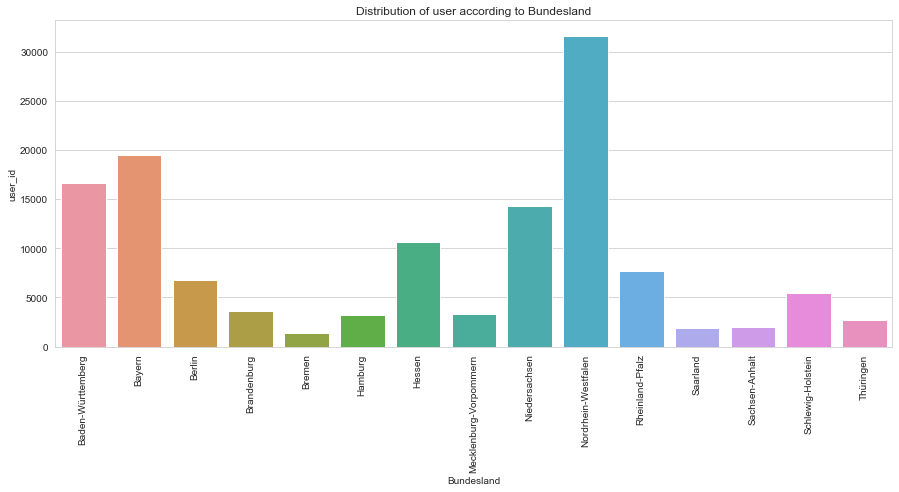

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.barplot(data = us_bund, x='Bundesland', y='user_id')
ax.set_xticklabels(us_bund['Bundesland'], rotation=90)
plt.title('Distribution of user according to Bundesland');

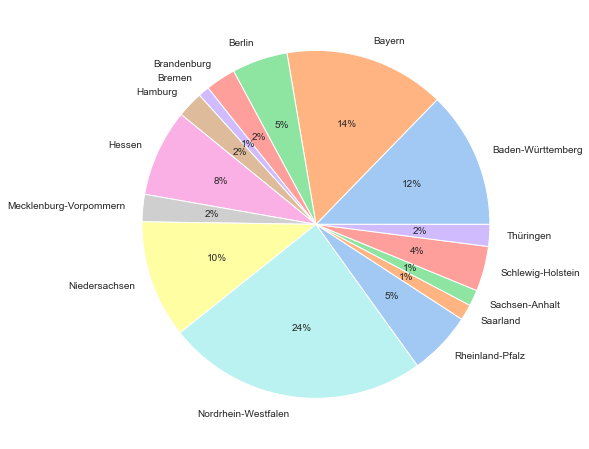

In [121]:
plt.figure(figsize=(8, 8))
plt.pie(us_bund['user_id'], labels=us_bund['Bundesland'], autopct='%d%%')
plt.show()

* We know that the column `Bundesland` has a huge amount of missing data (11.065%). From the above pipe chart, we see that most categories in this column occupy lower than 10%, except for few special areas. So I suggest to replace missing data with a new category called **unbekannt**


#### 3.2. replacing missing values of column `Bundesland` with `unbekannt` and missung values of column `Verwendungszweck` with the most frequent category in that column

In [122]:
df = df.fillna({'Bundesland': 'unbekannt', 'Verwendungszweck': df['Verwendungszweck'].value_counts().index[0]})

#### 3.3. Handling missing values of numemical variables
* Columns `angefragtes_Kreditvolumen` and `Alter`

##### 3.3.a. column Alter

In [123]:
df['Alter'].unique()

array([48, 38, 64, 29, 42, 44, 34, 32, 39, 40, 35, 37, 31, 60, 43, 66, 51,
       30, 45, 57, 69, 63, 41, 62, 65, 56, 46, 78, 36, 33, 50, 28, 2026,
       71, 73, 47, 58, 59, 77, 49, 68, 52, 61, 67, 74, 55, 72, 54, 79, 53,
       76, 70, 75, 27, 83, 80, <NA>, 9], dtype=object)

In [124]:
df_re[(df_re['Jahr_Geburt'] > 2023) | (df_re['Jahr_Geburt'] <= 1900)]

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded
51,310439250,Autokredit,2017-01-01 11:56:04,-3.0,3.0,DE,f,5.0,verheiratet / eingetragene Partnerschaft,zur Miete,2014-03-05 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
58,310440570,Existenzgründung,2017-01-01 12:07:08,-3.0,3.0,DE,f,7.5,ledig,bei den Eltern,2012-11-02 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
462,310559040,Ausgleich Girokonto / Dispo,2017-01-02 09:55:44,-3.0,3.0,DE,f,5.5,ledig,im Eigentum,1992-12-03 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
595,310665300,Autokredit,2017-01-02 12:17:53,-3.0,3.0,DE,f,20.0,verheiratet / eingetragene Partnerschaft,im Eigentum,1998-07-05 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
603,310668270,sonstiges,2017-01-02 12:22:58,-3.0,3.0,DE,f,6.0,ledig,zur Miete,2016-06-04 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144508,359017230,sonstiges,2017-05-29 17:31:55,-3.0,3.0,DE,m,10.0,verheiratet / eingetragene Partnerschaft,im Eigentum,2000-06-04 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
145217,359277435,Ausgleich Girokonto / Dispo,2017-05-30 13:51:30,-3.0,3.0,DE,m,7.5,geschieden,zur Miete,2013-03-05 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
145777,359466030,sonstiges,2017-05-30 23:20:52,-3.0,3.0,DE,m,1.0,ledig,bei den Eltern,2012-02-03 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
146290,359656440,Möbel / Renovierung / Umzug,2017-05-31 15:02:46,-3.0,3.0,DE,f,10.0,ledig,im Eigentum,1980-11-02 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5


In [125]:
df_re[df_re['Jahr_Geburt'] == -3.0]

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded
51,310439250,Autokredit,2017-01-01 11:56:04,-3.0,3.0,DE,f,5.0,verheiratet / eingetragene Partnerschaft,zur Miete,2014-03-05 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
58,310440570,Existenzgründung,2017-01-01 12:07:08,-3.0,3.0,DE,f,7.5,ledig,bei den Eltern,2012-11-02 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
462,310559040,Ausgleich Girokonto / Dispo,2017-01-02 09:55:44,-3.0,3.0,DE,f,5.5,ledig,im Eigentum,1992-12-03 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
595,310665300,Autokredit,2017-01-02 12:17:53,-3.0,3.0,DE,f,20.0,verheiratet / eingetragene Partnerschaft,im Eigentum,1998-07-05 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
603,310668270,sonstiges,2017-01-02 12:22:58,-3.0,3.0,DE,f,6.0,ledig,zur Miete,2016-06-04 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144508,359017230,sonstiges,2017-05-29 17:31:55,-3.0,3.0,DE,m,10.0,verheiratet / eingetragene Partnerschaft,im Eigentum,2000-06-04 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
145217,359277435,Ausgleich Girokonto / Dispo,2017-05-30 13:51:30,-3.0,3.0,DE,m,7.5,geschieden,zur Miete,2013-03-05 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
145777,359466030,sonstiges,2017-05-30 23:20:52,-3.0,3.0,DE,m,1.0,ledig,bei den Eltern,2012-02-03 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5
146290,359656440,Möbel / Renovierung / Umzug,2017-05-31 15:02:46,-3.0,3.0,DE,f,10.0,ledig,im Eigentum,1980-11-02 00:00:00,NaN,9630d5d23e65cdd4ecf28357798e4da5


In [126]:
df_re[(df_re['Jahr_Geburt'] >= 2013)]

,user_id,Verwendungszweck,Registrierungsdatum,Jahr_Geburt,Monat_Geburt,Staatsangehörigkeit,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,email_domain_encoded
123105,351931305,Existenzgründung,2017-05-04 21:52:12,2014.0,8.0,DE,f,20.0,ledig,zur Miete,2015-12-04 00:00:00,Nordrhein-Westfalen,d11f81fa8f2fe87afa697002ff2302ee


* After checking the unique values of column `Alter`, i saw some unsuall.
* Checking again the raw dataset `borrowed_registrations`, i find that there is a systematic problem in the column `Jahr_Geburt`. Because there is 758 user_id with `Jahr_Geburt` value = -3
* There is also one user, who is less than 18 year old. I don't know whether the service of company allows users under 18 years old or not.

--> **So I considere these data as outlier and try to fix it as well as missing values**


In [127]:
# Firstly, analyzing distribution of user according to Age
us_alt = df.groupby(['Alter']).agg({'user_id': 'count'}).sort_values(by='Alter', ascending=False).reset_index()
us_alt.head(5)

,Alter,user_id
0,2026,758
1,83,1
2,80,2
3,79,301
4,78,467


C:\Users\dream\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


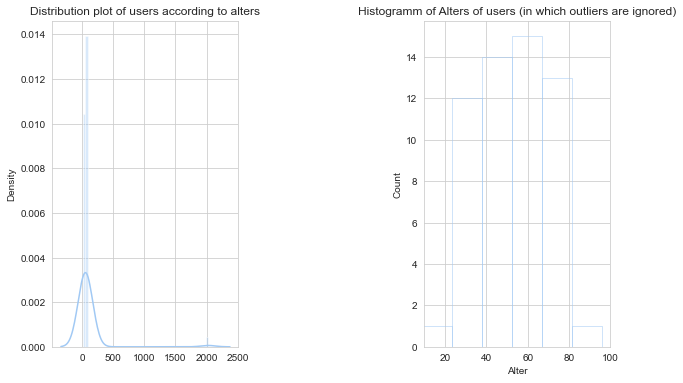

In [128]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.distplot(x=us_alt['Alter'])
plt.title('Distribution plot of users according to alters')

plt.subplot(1,2,2)
sns.histplot(data=us_alt, x='Alter', fill=False)
plt.xlim(10, 100)
plt.title("Histogramm of Alters of users (in which outliers are ignored)")
plt.subplots_adjust(wspace=1, hspace=1);

* So I will replace outliers and missing values with Median

In [129]:
median_alter = df['Alter'].median()
df['Alter'] = df['Alter'].fillna(median_alter)
df['Alter'] = df['Alter'].replace([9, 2026], median_alter)

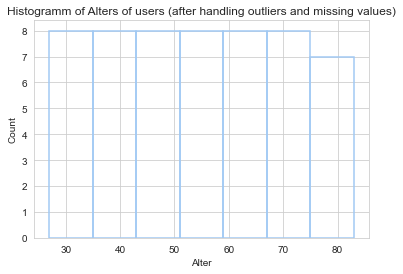

In [130]:
# Check again the distribution of user according to alter after handling outliers and missing values
us_al = df.groupby(['Alter']).agg({'user_id': 'count'}).sort_values(by='Alter', ascending=False).reset_index()
sns.histplot(data=us_al, x='Alter', fill=False)
plt.title("Histogramm of Alters of users (after handling outliers and missing values)")
plt.show()

##### 3.3.b column angefragtes_Kreditvolumen

In [131]:
us_kred = df.groupby('angefragtes_Kreditvolumen')['user_id'].count().reset_index()
us_kred.head(5)

,angefragtes_Kreditvolumen,user_id
0,1.0,15984
1,1.1,315
2,1.2,972
3,1.3,445
4,1.4,206


C:\Users\dream\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


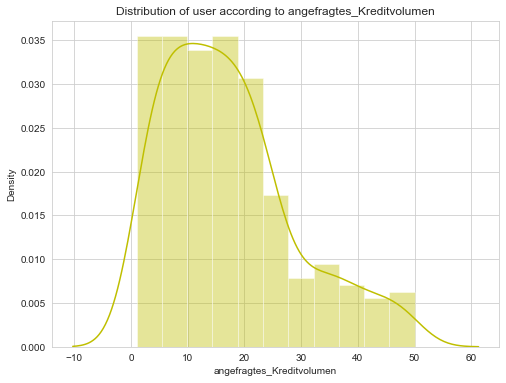

In [132]:
plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.distplot(us_kred['angefragtes_Kreditvolumen'], color='y')
#sns.kdeplot(data=us_kred['angefragtes_Kreditvolumen'])
plt.title('Distribution of user according to angefragtes_Kreditvolumen');

In [133]:
# Missing values in the column angefragtes_Kreditvolumen are replaced with the mean value of that column
df['angefragtes_Kreditvolumen'] = df['angefragtes_Kreditvolumen'].fillna(df['angefragtes_Kreditvolumen'].mean())

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146829 entries, 0 to 146828
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    146829 non-null  int64  
 1   Verwendungszweck           146829 non-null  object 
 2   Registrierungsdatum        146829 non-null  object 
 3   Geschlecht                 146829 non-null  object 
 4   angefragtes_Kreditvolumen  146829 non-null  float64
 5   Familienstand              146829 non-null  object 
 6   Wohnsituation              146829 non-null  object 
 7   dort_wohnhaft_seit         146742 non-null  object 
 8   Bundesland                 146829 non-null  object 
 9   Alter                      146829 non-null  float64
 10  num_miss_fields            146829 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 13.4+ MB


#### 3.4. Handling data type datetime
* a. Column `dort_wohnhaft_seit` has missing values and it should be analyzed further to know whether it is an important feature or not:

    * extract year in `dort_wohnhaft_seit` and then calculate the number of years up till now 
    
* b. Column `Registrierungsdatum`, in my opinion it is not really important for training model. So I'll drop it

In [135]:
# extract year in dort_wohnhaft_seit and then calculate the number of years up till now. year in apply() is the current year
df['anzahl_Wohnjahre'] = pd.to_datetime(df['dort_wohnhaft_seit']).dt.year.astype('Int64').apply(lambda x: year - x)

In [136]:
df['anzahl_Wohnjahre'].unique()

array([7, 9, 26, 11, 10, 8, 12, 36, 16, 54, 20, 33, 24, 21, 17, 15, 13,
       38, 14, 32, 23, 30, 34, 22, 31, 19, 44, 53, 25, 6, 28, 42, 27, 56,
       35, 18, 29, 60, 48, 65, 50, 61, 71, 46, 51, 43, <NA>, 40, 39, 37,
       58, 41, 55, 45, 67, 47, 113, 62, 49, 66, 69, 57, 52, 106, 63, 116,
       59, 108, 72, 123, 68, 73, 64, 75, 107, 79, 110, 109, 74, 70, 76,
       81, 111, 112, 82, 104, 92, 117, 135, 78, 121, 102, 124, 77, 128,
       84, 125, 138, 126, 119, 105], dtype=object)

In [137]:
us_wohnjahre = df.groupby('anzahl_Wohnjahre')['user_id'].count().reset_index()
us_wohnjahre.head(5)

,anzahl_Wohnjahre,user_id
0,6,185
1,7,25841
2,8,24158
3,9,16306
4,10,12201


C:\Users\dream\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


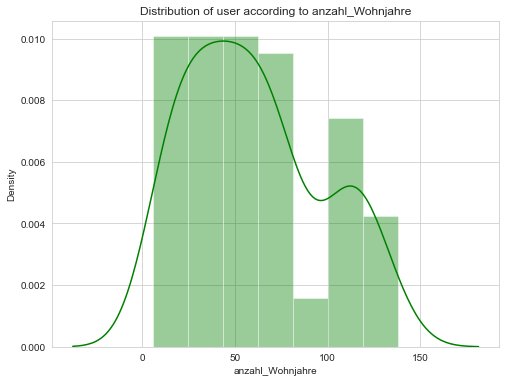

In [138]:
plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.distplot(us_wohnjahre['anzahl_Wohnjahre'], color='green')
#sns.kdeplot(data=us_kred['angefragtes_Kreditvolumen'])
plt.title('Distribution of user according to anzahl_Wohnjahre');

According to this plot, i consider to fill missing data of column `anzahl_Wohnjahre` mit Median of the column

In [139]:
median_wohnjahre = df['anzahl_Wohnjahre'].median()
df['anzahl_Wohnjahre'] = df['anzahl_Wohnjahre'].fillna(median_wohnjahre)

C:\Users\dream\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


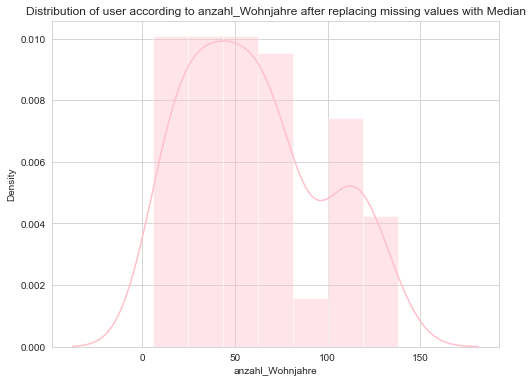

In [140]:
# plot again the data of column anzahl_Wohnjahre after replacing missing values
us_wohn = df.groupby('anzahl_Wohnjahre')['user_id'].count().reset_index()

plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.distplot(us_wohn['anzahl_Wohnjahre'], color='pink')
#sns.kdeplot(data=us_kred['angefragtes_Kreditvolumen'])
plt.title('Distribution of user according to anzahl_Wohnjahre after replacing missing values with Median');

In [141]:
df.head(5)

,user_id,Verwendungszweck,Registrierungsdatum,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,dort_wohnhaft_seit,Bundesland,Alter,num_miss_fields,anzahl_Wohnjahre
0,310426050,Existenzgründung,2017-01-01,f,10.0,ledig,zur Miete,2016-07-05,Bayern,48.0,0,7.0
1,310426380,Möbel / Renovierung / Umzug,2017-01-01,f,25.0,ledig,zur Miete,2014-02-02,Hessen,38.0,0,9.0
2,310426710,Möbel / Renovierung / Umzug,2017-01-01,m,5.0,getrennt lebend,zur Miete,2014-04-04,Hessen,64.0,0,9.0
3,310426875,Autokredit,2017-01-01,m,6.5,ledig,bei den Eltern,1997-03-05,Schlewig-Holstein,29.0,0,26.0
4,310427040,Möbel / Renovierung / Umzug,2017-01-01,f,6.5,ledig,bei den Eltern,2014-10-03,Baden-Württemberg,42.0,0,9.0


In [142]:
# drop columns Registrierungsdatum and dort_wohnhaft_seit
data = df.drop(columns= ['Registrierungsdatum', 'dort_wohnhaft_seit'])
data.head(5)

,user_id,Verwendungszweck,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,Bundesland,Alter,num_miss_fields,anzahl_Wohnjahre
0,310426050,Existenzgründung,f,10.0,ledig,zur Miete,Bayern,48.0,0,7.0
1,310426380,Möbel / Renovierung / Umzug,f,25.0,ledig,zur Miete,Hessen,38.0,0,9.0
2,310426710,Möbel / Renovierung / Umzug,m,5.0,getrennt lebend,zur Miete,Hessen,64.0,0,9.0
3,310426875,Autokredit,m,6.5,ledig,bei den Eltern,Schlewig-Holstein,29.0,0,26.0
4,310427040,Möbel / Renovierung / Umzug,f,6.5,ledig,bei den Eltern,Baden-Württemberg,42.0,0,9.0


### 4. Analyzing features

#### 4.1. Correlations between features

In [143]:
# Get correlation of features
corr_features = data.corr()
# visualize only one half of the heatmap
corr_ones = np.ones_like(corr_features, dtype = bool)
mask = np.triu(corr_ones)
# removing the first rows and first two columns of corr_features and mask
adjusted_corr_features = corr_features.iloc[1:, 1:]
adjusted_mask = mask[1:, 1:]
adjusted_corr_features

,angefragtes_Kreditvolumen,Alter,num_miss_fields,anzahl_Wohnjahre
angefragtes_Kreditvolumen,1.000000,0.134667,0.002810,0.067246
Alter,0.134667,1.000000,0.008875,0.260340
num_miss_fields,0.002810,0.008875,1.000000,0.014117
anzahl_Wohnjahre,0.067246,0.260340,0.014117,1.000000


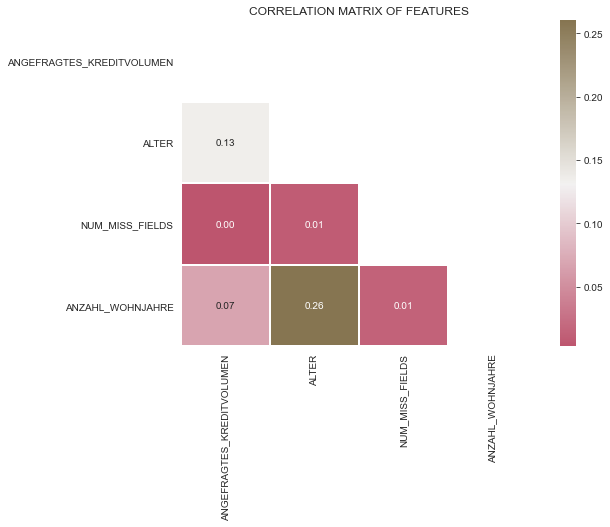

In [144]:
# draw the heatmap of corr_features
fig, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(360, 64, 51, as_cmap=True)
sns.heatmap(adjusted_corr_features, mask=adjusted_mask, annot=True, fmt='.2f', cmap=cmap, linecolor='white', linewidth=1)
yticks = [i.upper() for i in adjusted_corr_features.index]
xticks = [i.upper() for i in adjusted_corr_features.columns]
ax.set_yticklabels(yticks, rotation=0)
ax.set_xticklabels(xticks, rotation=90)
ax.set(title="CORRELATION MATRIX OF FEATURES");

"If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only needs one, as the second does not add additional information."

--> From the heatmap, we see that all features have no or low level of correlation with each other. So we keep all features to train models. Except for features `anzahl_Wohnjahre` and `Alter`, they may correlate with each other somehow. It is easy to understand, because most people tend to live for a long time in one place since their birth.

#### 4.2. Merge `data` with labels in file `borrower_labels.csv` and analysing the relationship between features and labels

In [145]:
df_lab['user_id'].duplicated().any()

False

In [146]:
# merge df_lab to data based on user_id
dataset = data.merge(df_lab, how='left', on='user_id')

In [147]:
dataset.head(5)

,user_id,Verwendungszweck,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,Bundesland,Alter,num_miss_fields,anzahl_Wohnjahre,flag_filled_page_2
0,310426050,Existenzgründung,f,10.0,ledig,zur Miete,Bayern,48.0,0,7.0,1
1,310426380,Möbel / Renovierung / Umzug,f,25.0,ledig,zur Miete,Hessen,38.0,0,9.0,0
2,310426710,Möbel / Renovierung / Umzug,m,5.0,getrennt lebend,zur Miete,Hessen,64.0,0,9.0,0
3,310426875,Autokredit,m,6.5,ledig,bei den Eltern,Schlewig-Holstein,29.0,0,26.0,1
4,310427040,Möbel / Renovierung / Umzug,f,6.5,ledig,bei den Eltern,Baden-Württemberg,42.0,0,9.0,1


#### a. Analyzing the relationship between gender and label

In [148]:
ge_lab = dataset.groupby(['Geschlecht', 'flag_filled_page_2']).agg({'user_id': 'count'}).reset_index()
ge_lab

,Geschlecht,flag_filled_page_2,user_id
0,f,0,45019
1,f,1,48518
2,m,0,28502
3,m,1,24790


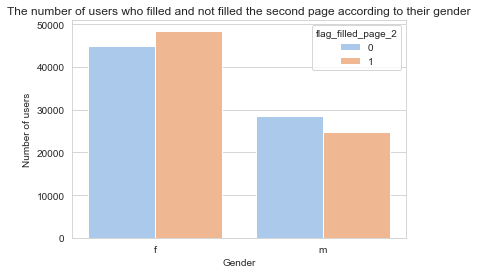

In [149]:
sns.barplot(data=ge_lab, x="Geschlecht", y="user_id", hue="flag_filled_page_2")
plt.ylabel('Number of users')
plt.xlabel('Gender')
plt.title('The number of users who filled and not filled the second page according to their gender')
plt.show()

* From the above grahp, we see that the number of female user is higher that that of male user. And female users tend to fill the second page more than male users.

--> women is patient than man =)))

#### b. Analyzing the relationship between num_miss_lab and label

In [150]:
num_miss_lab = dataset.groupby(['num_miss_fields', 'flag_filled_page_2']).agg({'user_id': 'count'}).reset_index()
num_miss_lab

,num_miss_fields,flag_filled_page_2,user_id
0,0,0,65040
1,0,1,65460
2,1,0,8454
3,1,1,7834
4,2,0,14
5,2,1,11
6,3,0,7
7,3,1,1
8,4,0,2
9,6,1,2


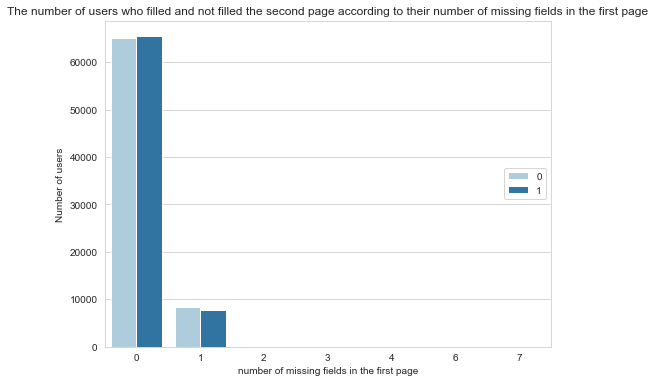

In [151]:
plt.figure(figsize=(8, 6))
sns.set_palette('Paired')
sns.barplot(data=num_miss_lab, x="num_miss_fields", y="user_id", hue="flag_filled_page_2")
plt.ylabel('Number of users')
plt.xlabel('number of missing fields in the first page')
plt.title('The number of users who filled and not filled the second page according to their number of missing fields in the first page')
plt.legend(loc=5)
plt.show()

* The more missing fields in the first page, the more tendency that user won't fill the second page

In [152]:
fam_lab = dataset.groupby(['Familienstand', 'flag_filled_page_2']).agg({'user_id': 'count'}).reset_index()
fam_lab

,Familienstand,flag_filled_page_2,user_id
0,geschieden,0,7711
1,geschieden,1,7495
2,getrennt lebend,0,2645
3,getrennt lebend,1,2973
4,ledig,0,44021
5,ledig,1,40269
6,verheiratet / eingetragene Partnerschaft,0,17627
7,verheiratet / eingetragene Partnerschaft,1,21719
8,verwitwet,0,1517
9,verwitwet,1,852


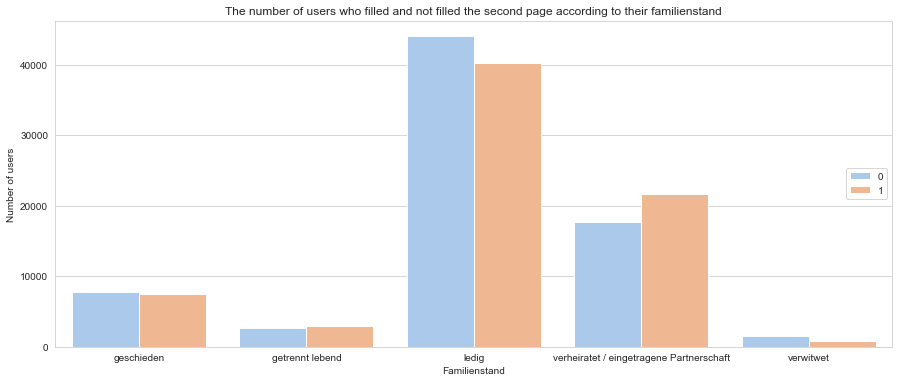

In [153]:
plt.figure(figsize=(15, 6))
sns.set_palette('pastel')
sns.barplot(data=fam_lab, x="Familienstand", y="user_id", hue="flag_filled_page_2")
plt.ylabel('Number of users')
plt.xlabel('Familienstand')
plt.title('The number of users who filled and not filled the second page according to their familienstand')
plt.legend(loc=5)
plt.show()

* Most users are single or get married. Single users tend to skip the second page, while people having family tend to fill the second page.

## III. Encoding categorical data 

* `Verwendungszweck`, `Geschlecht`, `Familienstand`, `Wohnsituation`, `Bundesland` are nominal categorical data, which as no particular order. 


* `Geschlecht`, `Wohnsituation`: i use the approach of one-hot encoding. Because the number of categories for these features are low
* `Verwendungszweck`, `Familienstand`, `Bundesland`: i use the approach of Binary encoding. Because the number of categories for these features are high


### 1. Split dataset into X and y data

In [180]:
X_dataset = dataset.drop(columns=['user_id', 'flag_filled_page_2']).copy()


In [181]:
X_dataset.head(5)

,Verwendungszweck,Geschlecht,angefragtes_Kreditvolumen,Familienstand,Wohnsituation,Bundesland,Alter,num_miss_fields,anzahl_Wohnjahre
0,Existenzgründung,f,10.0,ledig,zur Miete,Bayern,48.0,0,7.0
1,Möbel / Renovierung / Umzug,f,25.0,ledig,zur Miete,Hessen,38.0,0,9.0
2,Möbel / Renovierung / Umzug,m,5.0,getrennt lebend,zur Miete,Hessen,64.0,0,9.0
3,Autokredit,m,6.5,ledig,bei den Eltern,Schlewig-Holstein,29.0,0,26.0
4,Möbel / Renovierung / Umzug,f,6.5,ledig,bei den Eltern,Baden-Württemberg,42.0,0,9.0


In [182]:
y = dataset.iloc[:, -1].values
y

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

### 2. One-hot encoding for Geschlecht, Wohnsituation

In [183]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['Geschlecht', 'Wohnsituation'])], remainder="passthrough")
X_dataset = np.array(ct.fit_transform(X_dataset))

In [184]:
# after implementing OneHotEncoder, X_dataset has no feature name. So I try to get the feature name for the dataset
columns_name = ct.get_feature_names()
X_df = pd.DataFrame(X_dataset, columns=columns_name)

In [185]:
X_df.head(5)

,encoder__x0_f,encoder__x0_m,encoder__x1_bei den Eltern,encoder__x1_im Eigentum,encoder__x1_zur Miete,Verwendungszweck,angefragtes_Kreditvolumen,Familienstand,Bundesland,Alter,num_miss_fields,anzahl_Wohnjahre
0,1.0,0.0,0.0,0.0,1.0,Existenzgründung,10.0,ledig,Bayern,48.0,0,7.0
1,1.0,0.0,0.0,0.0,1.0,Möbel / Renovierung / Umzug,25.0,ledig,Hessen,38.0,0,9.0
2,0.0,1.0,0.0,0.0,1.0,Möbel / Renovierung / Umzug,5.0,getrennt lebend,Hessen,64.0,0,9.0
3,0.0,1.0,1.0,0.0,0.0,Autokredit,6.5,ledig,Schlewig-Holstein,29.0,0,26.0
4,1.0,0.0,1.0,0.0,0.0,Möbel / Renovierung / Umzug,6.5,ledig,Baden-Württemberg,42.0,0,9.0


### 3. Binary encoding for Verwendungszweck, Familienstand, Bundesland

In [186]:
from category_encoders import BinaryEncoder
X = BinaryEncoder(cols=['Verwendungszweck', 'Familienstand', 'Bundesland'], drop_invariant = True).fit_transform(X_df)

In [187]:
X.head(5)

,encoder__x0_f,encoder__x0_m,encoder__x1_bei den Eltern,encoder__x1_im Eigentum,encoder__x1_zur Miete,Verwendungszweck_0,Verwendungszweck_1,Verwendungszweck_2,Verwendungszweck_3,angefragtes_Kreditvolumen,...,Familienstand_1,Familienstand_2,Bundesland_0,Bundesland_1,Bundesland_2,Bundesland_3,Bundesland_4,Alter,num_miss_fields,anzahl_Wohnjahre
0,1.0,0.0,0.0,0.0,1.0,0,0,0,1,10.0,...,0,1,0,0,0,0,1,48.0,0,7.0
1,1.0,0.0,0.0,0.0,1.0,0,0,1,0,25.0,...,0,1,0,0,0,1,0,38.0,0,9.0
2,0.0,1.0,0.0,0.0,1.0,0,0,1,0,5.0,...,1,0,0,0,0,1,0,64.0,0,9.0
3,0.0,1.0,1.0,0.0,0.0,0,0,1,1,6.5,...,0,1,0,0,0,1,1,29.0,0,26.0
4,1.0,0.0,1.0,0.0,0.0,0,0,1,0,6.5,...,0,1,0,0,1,0,0,42.0,0,9.0


### 4. Check balance in labels

In [188]:
# Check balance in labels
y_dataset = pd.DataFrame(dataset['flag_filled_page_2'].copy(), columns=['flag_filled_page_2'])
print(f"The percentage of label 0 in dataset: {round((len(y_dataset[y_dataset['flag_filled_page_2'] == 0]) / len(y_dataset) * 100), 2)} %")


The percentage of label 0 in dataset: 50.07 %


### 5. Split the dataset into training set and test set

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 6. Feature scaling

In [190]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [191]:
X_train

array([[-1.32560098,  1.32560098, -0.46410594, ...,  1.10341463,
        -0.35123154, -0.28410391],
       [ 0.75437482, -0.75437482, -0.46410594, ...,  1.02287356,
        -0.35123154,  0.49296568],
       [ 0.75437482, -0.75437482, -0.46410594, ...,  0.62016822,
        -0.35123154,  0.15993586],
       ...,
       [-1.32560098,  1.32560098, -0.46410594, ..., -0.1047014 ,
         2.78330048,  0.04892591],
       [ 0.75437482, -0.75437482, -0.46410594, ...,  0.37854501,
        -0.35123154, -0.61713373],
       [ 0.75437482, -0.75437482, -0.46410594, ..., -0.42686567,
        -0.35123154, -0.72814367]])

## IV. Training models

### 1. Random Forest Classification Model

#### a. Training the Random Forest Classification model on the Training set

In [192]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

#### b. Predicting the test set result

In [193]:
y_pred = classifier.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

#### c. Making confusion matrix and calculating accuracy score

Confusion matrix:


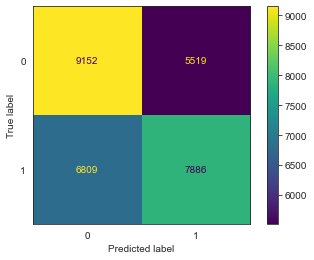

Accuracy score: 0.5801947830824763
Precision score: [0.57339766 0.58828795]
Recall score: [0.62381569 0.53664512]
f1 score: [0.59754505 0.56128114]


In [214]:
sns.set_style('white')
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {ac}")

prec = precision_score(y_test, y_pred, average = None)
print(f"Precision score: {prec}")

recall = recall_score(y_test, y_pred, average = None)
print(f"Recall score: {recall}")

f1_sc = f1_score(y_test, y_pred, average = None)
print(f"f1 score: {f1_sc}")

#### d. Applying k-Fold Cross Validation on test set

In [236]:
from sklearn.model_selection import cross_val_score
accu = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accu.mean()*100))
print("Standard Deviation: {:.2f} %".format(accu.std()*100))

Accuracy: 58.32 %
Standard Deviation: 0.55 %


### 2. Decision Tree Classification Model

#### a. Training the Decision Tree Classification model on the Training set

In [200]:
from sklearn.tree import DecisionTreeClassifier
cl_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
cl_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

#### b. Predicting the test set result

In [201]:
y_pred_tree = cl_tree.predict(X_test)

#### c. Making confusion matrix and calculating accuracy score

Confusion matrix:


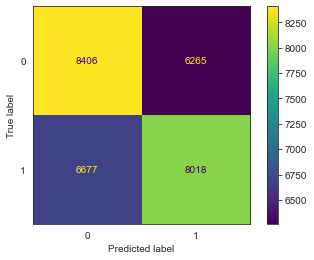

Accuracy score: 0.5592862494040728
Precision score: [0.55731618 0.56136666]
Recall score: [0.62381569 0.53664512]
f1 score: [0.56503327 0.55338533]


In [215]:
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=cl_tree.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix = cm_tree, display_labels = cl_tree.classes_)
disp.plot()
plt.show()

ac_tree = accuracy_score(y_test, y_pred_tree)
print(f"Accuracy score: {ac_tree}")

prec_tree = precision_score(y_test, y_pred_tree, average = None)
print(f"Precision score: {prec_tree}")

recall_tree = recall_score(y_test, y_pred_tree, average = None)
print(f"Recall score: {recall}")

f1_sc_tree = f1_score(y_test, y_pred_tree, average = None)
print(f"f1 score: {f1_sc_tree}")

### 3. Using GridSearchCV to train model

In [205]:
from sklearn.model_selection import GridSearchCV
dTree = DecisionTreeClassifier()
params = {'criterion' : ['gini', 'entropy'], 
          'min_samples_split' : np.arange(2, 5),
          'min_samples_leaf' : np.arange(1, 3),
          'max_leaf_nodes' : np.arange(2, 5),
          'max_depth' : np.arange(2, 5)}
clf = GridSearchCV(estimator=dTree, param_grid=params, error_score='raise', n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_leaf_nodes': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [210]:
y_pred_grid = clf.predict(X_test)

Confusion matrix:


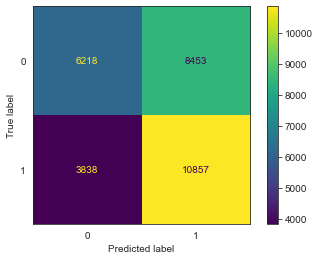

Accuracy score: 0.581454743581012
Precision score: [0.61833731 0.56224754]
Recall score: [0.42382932 0.73882273]
f1 score: [0.50293202 0.63855315]


In [216]:
cm_grid = confusion_matrix(y_test, y_pred_grid, labels = clf.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix = cm_grid, display_labels = clf.classes_)
disp.plot()
plt.show()

ac_grid = accuracy_score(y_test, y_pred_grid)
print(f"Accuracy score: {ac_grid}")

prec_grid = precision_score(y_test, y_pred_grid, average = None)
print(f"Precision score: {prec_grid}")

recall_grid = recall_score(y_test, y_pred_grid, average = None)
print(f"Recall score: {recall_grid}")

f1_sc_grid = f1_score(y_test, y_pred_grid, average = None)
print(f"f1 score: {f1_sc_grid}")

### 4. Support Vector Machine Model

#### a. Training the SVM model on the Training set

In [207]:
from sklearn.svm import SVC
cl_svm = SVC(kernel = 'linear', random_state=0)
cl_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

#### b. Predicting the test set result

In [208]:
y_pred_svm = cl_svm.predict(X_test)

#### c. Making confusion matrix and calculating accuracy score

Confusion matrix:


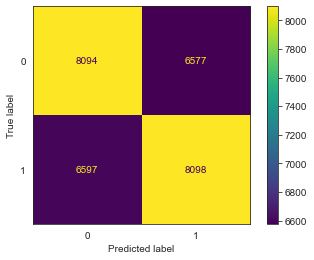

Accuracy score: 0.5513859565483893
Precision score: [0.55094956 0.55182283]
Recall score: [0.55170063 0.55107179]
f1 score: [0.55132484 0.55144705]


In [217]:
cm_svm = confusion_matrix(y_test, y_pred_svm, labels = cl_svm.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix = cm_svm, display_labels = cl_svm.classes_)
disp.plot()
plt.show()

ac_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy score: {ac_svm}")

prec_svm = precision_score(y_test, y_pred_svm, average = None)
print(f"Precision score: {prec_svm}")

recall_svm = recall_score(y_test, y_pred_svm, average = None)
print(f"Recall score: {recall_svm}")

f1_sc_svm = f1_score(y_test, y_pred_svm, average = None)
print(f"f1 score: {f1_sc_svm}")

### 5. K-Nearest Neighbors (KNN) Model

In [219]:
from sklearn.neighbors import KNeighborsClassifier
cl_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
cl_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [220]:
y_pred_knn = cl_knn.predict(X_test)

Confusion matrix:


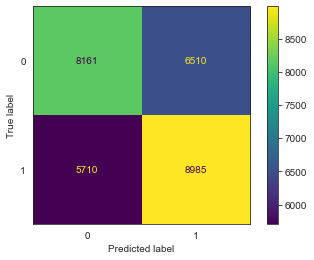

Accuracy score: 0.5838725056187427
Precision score: [0.58834979 0.57986447]
Recall score: [0.55626747 0.61143246]
f1 score: [0.57185901 0.59523021]


In [221]:
cm_knn = confusion_matrix(y_test, y_pred_knn, labels = cl_knn.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = cl_knn.classes_)
disp.plot()
plt.show()

ac_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy score: {ac_knn}")

prec_knn = precision_score(y_test, y_pred_knn, average = None)
print(f"Precision score: {prec_knn}")

recall_knn = recall_score(y_test, y_pred_knn, average = None)
print(f"Recall score: {recall_knn}")

f1_sc_knn = f1_score(y_test, y_pred_knn, average = None)
print(f"f1 score: {f1_sc_knn}")

### 6. Naive Bayes Model

In [222]:
from sklearn.naive_bayes import GaussianNB
cl_nb = GaussianNB()
cl_nb.fit(X_train, y_train)

GaussianNB()

In [223]:
y_pred_nb = cl_nb.predict(X_test)

Confusion matrix:


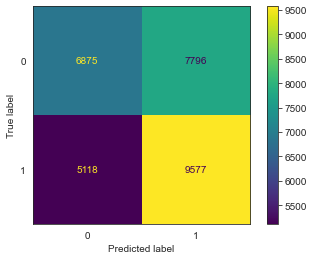

Accuracy score: 0.5602397330245863
Precision score: [0.57325106 0.5512577 ]
Recall score: [0.46861155 0.65171827]
f1 score: [0.51567657 0.59729325]


In [225]:
cm_nb = confusion_matrix(y_test, y_pred_nb, labels = cl_nb.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix = cm_nb, display_labels = cl_nb.classes_)
disp.plot()
plt.show()

ac_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy score: {ac_nb}")

prec_nb = precision_score(y_test, y_pred_nb, average = None)
print(f"Precision score: {prec_nb}")

recall_nb = recall_score(y_test, y_pred_nb, average = None)
print(f"Recall score: {recall_nb}")

f1_sc_nb = f1_score(y_test, y_pred_nb, average = None)
print(f"f1 score: {f1_sc_nb}")

### 7. XGBoost model

In [231]:
!pip install xgboost

  Using cached xgboost-1.7.4-py3-none-win_amd64.whl (89.1 MB)


#### a. Training the xbBoost model on the Training set

In [232]:
from xgboost import XGBClassifier
cl_xgb = XGBClassifier()
cl_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### b. Predicting the test set result

In [233]:
y_pred_xgb = cl_xgb.predict(X_test)

#### c. Making confusion matrix and calculating accuracy score

Confusion matrix:


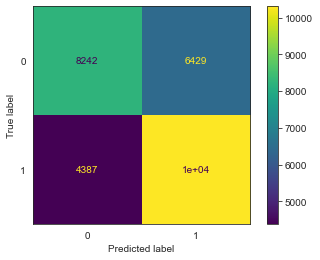

Accuracy score: 0.6316828985902063
Precision score: [0.65262491 0.61588098]
Recall score: [0.56178856 0.70146308]
f1 score: [0.60380952 0.65589208]


In [234]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels = cl_xgb.classes_)
print("Confusion matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = cl_xgb.classes_)
disp.plot()
plt.show()

ac_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy score: {ac_xgb}")

prec_xgb = precision_score(y_test, y_pred_xgb, average = None)
print(f"Precision score: {prec_xgb}")

recall_xgb = recall_score(y_test, y_pred_xgb, average = None)
print(f"Recall score: {recall_xgb}")

f1_sc_xgb = f1_score(y_test, y_pred_xgb, average = None)
print(f"f1 score: {f1_sc_xgb}")

#### d. Applying k-Fold Cross Validation on test set

In [235]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = cl_xgb, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 63.38 %
Standard Deviation: 0.45 %


## V. Model Selection

Deine Aufgabe ist es nun ein Vorhersagemodell zu trainieren, dass nur anhand der Fakten aus der oberen Tabelle ausgibt, welche User sehr wahrscheinlich NICHT die zweite Seite ausfüllen werden.

In [243]:
y_dataset = pd.DataFrame(dataset['flag_filled_page_2'].copy(), columns=['flag_filled_page_2'])
print(f"The actual number of 0_labels in dataset: {len(y_dataset[y_dataset['flag_filled_page_2'] == 0])}")
print(f"The actual number of 1_labels in dataset: {len(y_dataset[y_dataset['flag_filled_page_2'] == 1])}")

The actual number of 0_labels in dataset: 73521
The actual number of 1_labels in dataset: 73308


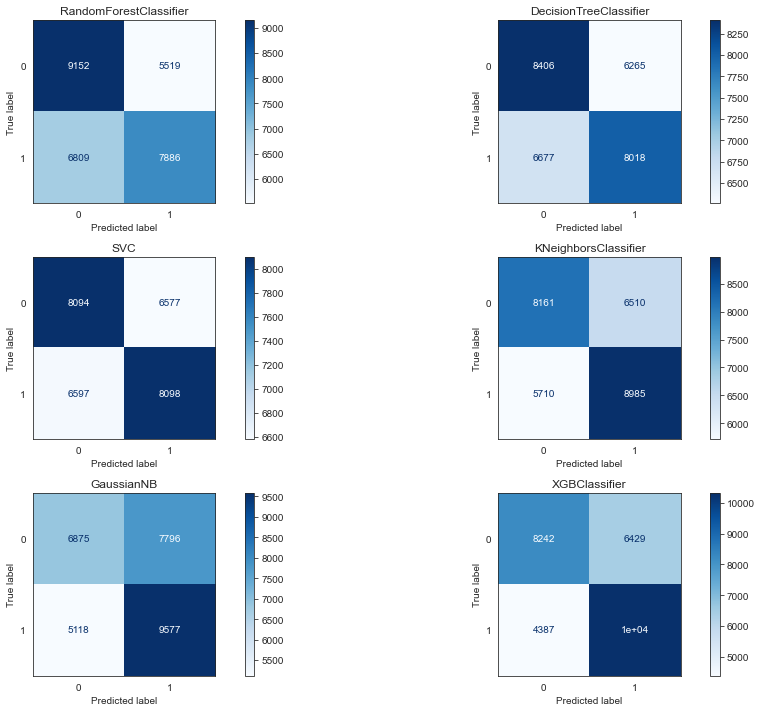

In [268]:
from sklearn.metrics import plot_confusion_matrix
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

classifiers = [RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0), 
               DecisionTreeClassifier(criterion = 'entropy', random_state = 0),
               SVC(kernel = 'linear', random_state=0), 
               KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
               GaussianNB(),
               XGBClassifier()]
for cls in classifiers:
    cls.fit(X_train, y_train)


#classifier = [classifier, cl_tree, cl_knn, cl_svm, cl_nb, cl_xgb]

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=cls.classes_)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

In [271]:
print(f"Random Forest_Accuracy:  \t\t {round(ac, 2)}")
print(f"Decision Tree_Accurarcy: \t\t {round(ac_tree, 2)}")
print(f"SVM_Accurrary: \t\t {round(ac_svm, 2)}")
print(f"KNN_Accuracy: \t\t {round(ac_knn, 2)}")
print(f"Navie Bayes_Accuracy: \t\t {round(ac_nb, 2)}")
print(f"XGBBoost_Accuracy: \t\t {round(ac_xgb, 2)}")

Random Forest_Accuracy:  		 0.58
Decision Tree_Accurarcy: 		 0.56
SVM_Accurrary: 		 0.55
KNN_Accuracy: 		 0.58
Navie Bayes_Accuracy: 		 0.56
XGBBoost_Accuracy: 		 0.63


* Although XGBBoost has the highest accuracy score, our aim is to predict as much as possible user who won't fill the second page. So based on the confusion matrix, i choose Random Forest Classification model